# 📝 Notebook-Dokumentation

**Notebook:** `21_isochronen__...`  
**Beschreibung:**  
Berechnet Isochronen über die GraphHopper-API für Startpunkte aus 100m-Rastern, gefiltert nach Postleitzahlen oder Regionstypen (z. B. `regiostar7`).  
Das Notebook prüft zusätzlich, welche Isochronen bereits vorhanden sind, um abgebrochene Prozesse effizient fortzusetzen.

---

### 📥 Input

- **Konfiguration (Parameter für die Isochronen-Berechnung)**  
  (z. B. Zeitintervalle, Verkehrsmittel etc.)

- **Startpunkte**  
  - Centroiden aus 100m-Rastern
  - Auswahl der Rasterzellen basiert auf Postleitzahlen
  - Optionale Filterung über `regiostar7`-Kategorien

- **Bisher erzeugte Isochronen-Dateien**  
  (zur Vermeidung doppelter Anfragen und zur Wiederaufnahme abgebrochener Prozesse)

---

### 🔧 Verarbeitungsschritte

- Laden und Filtern der Startpunkte (100m-Raster, PLZ, `regiostar7`)
- Prüfung bestehender Ergebnisse (welche Isochronen existieren bereits?)
- Erstellung von GraphHopper-Requests für fehlende Punkte
- Speichern der Ergebnisse (z. B. als Parquet)
- Fortschritts-Logging

---

### 📤 Output

- Verzeichnis mit Isochronen-Dateien (z. B. `/isochronen/{scenario_name}/86830_25-05-09_isochrones_6x5min__bike.parquet`)
- Log-Dateien oder Status-Dateien für Monitoring und Wiederaufnahme

---




In [37]:
import json
import pandas as pd
import geopandas as gpd

import requests
import contextily as ctx

import requests
import json
import os
import sys
import time
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from datetime import datetime

### set output directory here

In [76]:
scenario_name="test_plz_88636"

# Ensure output directory exists
output_dir  = f"isochronen/{scenario_name}/"
os.makedirs(output_dir , exist_ok=True)

In [77]:
## helper function

def calcTimeBuckets(bucket, time_limit, buckets_no):
    
    time_per_bucket=(time_limit/buckets_no)/60
    
    bucket+=1
    timebucket=bucket*time_per_bucket
    
    return timebucket

### test fuctioniality 

Text(0.5, 1.01, 'GH localhost Isochones \n Start:Kall; custom profil cargo bike (average_slope)')

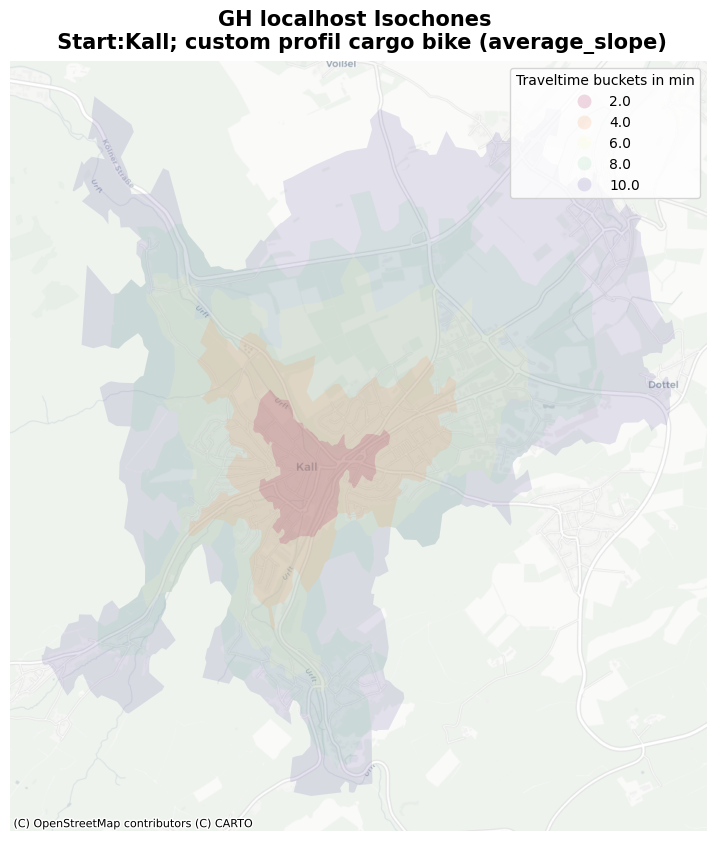

In [78]:
import requests

url = "http://radverkehr-analytics.inw.th-wildau.de:8979/isochrone"
#url = "http://localhost:8990/isochrone"


time_limit=10*60
buckets=5

query = {
  "point": "50.54098,6.55721",
  "time_limit": str(time_limit),
  "distance_limit": "0",
  "profile": "cargo_bike",   #"profile": "bike",
  "buckets": str(buckets),
  "reverse_flow": "false",
}

response = requests.get(url, params=query)

data = response.json()

# response to gdf
pretty_json = json.loads(response.text)
gdf = gpd.GeoDataFrame.from_features(pretty_json["polygons"])

#prepare time_buckets for plotting
gdf['time_bucket']=gdf.bucket.apply(lambda x: calcTimeBuckets(x,time_limit,buckets))

#transform crs
gdf.crs=4326
gdf_plot = gdf.to_crs(3857)

#plotting
ax=gdf_plot.sort_values("time_bucket", ascending=False).plot(
    #title="GH localhost Isochones - Start:Schillerkiez; profile bike (average_slope)",
    column='time_bucket', categorical=True, 
    cmap='Spectral', legend=True, alpha=0.15, figsize=(10,10),
    legend_kwds={'title': "Traveltime buckets in min"})
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.axis('off')

ax.text(x=0.5, y=1.01, s='GH localhost Isochones \n Start:Kall; custom profil cargo bike (average_slope)', fontsize=15, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

## Population GER

In [79]:
pop_raster_poly_cent= gpd.read_parquet("data/base_data/Zensus2022_100m_cent_GER_wPLZ_wRS.parquet")
pop_raster_poly_cent.head()

,id,GITTER_ID_100m,ags,Einwohner,AnteilAuslaender,Durchschnittsalter,Unter18,a18bis29,a30bis49,a50bis64,...,a1979bis1990,a1991bis2000,a2001bis2010,a2011bis2019,a2020undspaeter,plz,geometry,gem_23_str,name_23,RegioStaR7
0,100mN27509E41617,CRS3035RES100mN2750900E4161700,08315130,4,0.0,46.180000,0,0,3,0,...,0.0,0.0,0.0,0.0,0.0,79244,POINT (7.873 47.85154),08315130,Münstertal/Schwarzwald,74
1,100mN27373E42562,CRS3035RES100mN2737300E4256200,08335043,3,0.0,83.959999,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,78465,POINT (9.13706 47.74636),08335043,"Konstanz, Universitätsstadt",75
2,100mN28729E44475,CRS3035RES100mN2872900E4447500,09273164,4,0.0,89.919998,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,93339,POINT (11.72766 48.9564),09273164,"Riedenburg, St",74
3,100mN27710E43359,CRS3035RES100mN2771000E4335900,09778177,4,0.0,33.520000,0,3,3,0,...,NaN,NaN,NaN,NaN,NaN,87767,POINT (10.20044 48.05284),09778177,Niederrieden,77
4,100mN27821E43665,CRS3035RES100mN2782100E4366500,09778169,4,0.0,23.820000,3,0,3,0,...,NaN,NaN,NaN,NaN,NaN,86865,POINT (10.61188 48.1512),09778169,"Markt Wald, M",77


### Wähle den Filter den du Anwenden willst

### filter regiostar

In [67]:
# filter regiostar
sel_regiostar=[75,76,77]
pop_raster_poly_cent_fil=pop_raster_poly_cent[pop_raster_poly_cent.RegioStaR7.isin(sel_regiostar)].copy()
plz_fil=pop_raster_poly_cent_fil.plz.unique()
plz_fil = plz_fil[plz_fil != None]
plz_fil_list=list(plz_fil)


# Anzahl ausgeben
print(f"Gefiltert nach RegioStaR7 ∈ {sel_regiostar}")
print(f"Anzahl eindeutiger Postleitzahlen: {len(plz_fil):,} von insgesamt {len(pop_raster_poly_cent.plz.unique()):,}")
print(f"Anzahl 100m-Rasterzellen: {len(pop_raster_poly_cent_fil):,} von insgesamt {len(pop_raster_poly_cent):,}")

Gefiltert nach RegioStaR7 ∈ [75, 76, 77]
Anzahl eindeutiger Postleitzahlen: 4,545 von insgesamt 8,160
Anzahl 100m-Rasterzellen: 1,643,350 von insgesamt 3,081,328


### filter PLZ

In [80]:
# alternativ filter PLZ
sel_plz=["88636"]
pop_raster_poly_cent_fil=pop_raster_poly_cent[pop_raster_poly_cent.plz.isin(sel_plz)].copy()
plz_fil=pop_raster_poly_cent_fil.plz.unique()
plz_fil_list=list(plz_fil)

# Anzahl ausgeben
print(f"Gefiltert nach PLZ {plz}")
print(f"Anzahl eindeutiger Postleitzahlen: {len(plz_fil):,} von insgesamt {len(pop_raster_poly_cent.plz.unique()):,}")
print(f"Anzahl 100m-Rasterzellen: {len(pop_raster_poly_cent_fil):,} von insgesamt {len(pop_raster_poly_cent):,}")

Gefiltert nach PLZ ['88636']
Anzahl eindeutiger Postleitzahlen: 1 von insgesamt 8,160
Anzahl 100m-Rasterzellen: 166 von insgesamt 3,081,328


###  Check if the previous run already produce the selected PLZ

In [81]:
import glob
import re
from collections import Counter

# Get all files in the output folder folder
files = glob.glob(f"{output_dir}/*")

# Extract PLZ (assuming it's the first numeric part of the filename)
plz_list = []
for file in files:
    match = re.search(r"(\d{5})", file)  # Looks for a 5-digit number
    if match:
        plz_list.append(match.group(1))

# Count occurrences of each PLZ
plz_counts = Counter(plz_list)

# Filter PLZs that appear at least 3 times
existing_plz_isochrone = [plz for plz, count in plz_counts.items() if count >= 3]

# Find PLZs that did not appear at least 3 times
invalid_plz = [plz for plz, count in plz_counts.items() if count < 3]

# Print results
print("PLZs that appeared at least 3 times:", existing_plz_isochrone)
#print("PLZs that appeared at least 3 times, number:", len(valid_plz_isochrone))
#print("PLZs that did NOT appear 3 times:", invalid_plz)



##or simpler do something link this:
#index_25867 = plz_fil_list.index("25867")
#len(plz_fil_list[index_25867:])

PLZs that appeared at least 3 times: []


In [82]:
valid_plz_difference = list(set(plz_fil_list) - set(existing_plz_isochrone))
valid_plz_difference

['88636']

### ISO-Berechnung!!

In [83]:


# input plz list
input_plz=valid_plz_difference #plz_fil_list #valid_plz_difference






# Parameters
time_limit = 30 * 60
buckets = 6
time_limit_bucket = int(time_limit / 60 / buckets)
modes = ["bike", "my_bike_cycleways", "cargo_bike"]

# URL for API
url = "http://radverkehr-analytics.inw.th-wildau.de:8979/isochrone"

# Get current date dynamically (YY-MM-DD format)
current_date = datetime.today().strftime("%y-%m-%d")


# Function to generate unique log file
def get_log_filename():
    base_filename = f"{output_dir}{current_date}_log"
    if not os.path.exists(base_filename + ".txt"):
        return base_filename + ".txt"
    
    counter = 1
    while os.path.exists(f"{base_filename}-{counter}.txt"):
        counter += 1
    return f"{base_filename}-{counter}.txt"

# Generate log filename
log_filename = get_log_filename()

# Function to write logs
def log_message(message):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_entry = f"[{timestamp}] {message}\n"
    with open(log_filename, "a", encoding="utf-8") as log_file:
        log_file.write(log_entry)
    print(log_entry.strip())  # Also print to console

# Capture unexpected errors in logs
def log_exception(exc_type, exc_value, exc_traceback):
    log_message(f"ERROR: {exc_type.__name__}: {exc_value}")

sys.excepthook = log_exception  # Catch unexpected errors and log them

# Start logging
log_message(f"=== Script started (Log file: {log_filename}) ===")

try:
   # for p in all_plz_rbzKoeln:
    for idx, p in enumerate(input_plz, start=1):
        log_message(f"Processing PLZ {idx}/{len(input_plz)}: {p}")
        pop_raster_poly_cent_plz = pop_raster_poly_cent[pop_raster_poly_cent.plz == p].copy()
        log_message(f"  Number of Tiles: {len(pop_raster_poly_cent_plz)}")
        
        for m in modes:
            log_message(f"    Mode: {m}")
            isos_all = gpd.GeoDataFrame()

            for index, row in tqdm(pop_raster_poly_cent_plz.iterrows(), total=len(pop_raster_poly_cent_plz), desc=f"Processing {p} - {m}"):
                query = {
                    "point": f"{row['geometry'].y},{row['geometry'].x}",
                    "time_limit": str(time_limit),
                    "distance_limit": "0",
                    "profile": m,
                    "buckets": str(buckets),
                    "reverse_flow": "false",
                }

                response = requests.get(url, params=query)

                if response.status_code == 200 and response.text.strip():
                    data = response.json()
                else:
                    log_message(f"Error: Empty response or bad request for {p} - {m} at {row['geometry']}")
                    continue  # Skip this iteration

                # Convert response to GeoDataFrame
                pretty_json = json.loads(response.text)
                isos = gpd.GeoDataFrame.from_features(pretty_json["polygons"])

                # Prepare time_buckets for plotting
                isos["time_bucket"] = isos.bucket.apply(lambda x: calcTimeBuckets(x, time_limit, buckets))
                isos["id"] = row["id"]

                # Append to result
                isos_all = pd.concat([isos_all, isos])

            # Save output
            isos_all.crs = 4326
            #output_path = f"data/isos/{p}_{current_date}_isochrones_{buckets}x{time_limit_bucket}min__{m}.parquet"
            #output_path = f"../../storage/isos_ger/{p}_{current_date}_isochrones_{buckets}x{time_limit_bucket}min__{m}.parquet"
            output_path = os.path.join(output_dir, f"{p}_{current_date}_isochrones_{buckets}x{time_limit_bucket}min__{m}.parquet")
            isos_all.to_parquet(output_path)

            log_message(f"    Saved: {output_path}")

    log_message("=== Script finished successfully ===")

except Exception as e:
    log_message(f"CRITICAL ERROR: {e}")
    sys.exit(1)  # Exit the script with error status


[2025-05-21 12:48:34] === Script started (Log file: isochronen/test_plz_88636/25-05-21_log.txt) ===
[2025-05-21 12:48:34] Processing PLZ 1/1: 88636
[2025-05-21 12:48:35]   Number of Tiles: 166
[2025-05-21 12:48:35]     Mode: bike


Processing 88636 - bike: 100%|██████████| 166/166 [00:19<00:00,  8.64it/s]


[2025-05-21 12:48:54]     Saved: isochronen/test_plz_88636/88636_25-05-21_isochrones_6x5min__bike.parquet
[2025-05-21 12:48:54]     Mode: my_bike_cycleways


Processing 88636 - my_bike_cycleways: 100%|██████████| 166/166 [00:16<00:00,  9.87it/s]


[2025-05-21 12:49:11]     Saved: isochronen/test_plz_88636/88636_25-05-21_isochrones_6x5min__my_bike_cycleways.parquet
[2025-05-21 12:49:11]     Mode: cargo_bike


Processing 88636 - cargo_bike: 100%|██████████| 166/166 [00:31<00:00,  5.28it/s]


[2025-05-21 12:49:42]     Saved: isochronen/test_plz_88636/88636_25-05-21_isochrones_6x5min__cargo_bike.parquet
[2025-05-21 12:49:42] === Script finished successfully ===
